In [1]:
import numpy as np
from scipy.stats import norm, lognorm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append("..")
from src.dataset import CRKPTransmissionSimulator
from timeit import default_timer as timer

In [2]:
## load data
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'

In [3]:
with open(f"{epi_dir}/observed_data.npy", "rb") as f:
            x_o = np.load(f)

## homogeneous run

In [10]:
prior_mu = -1
prior_sigma = 1

In [12]:
# best run: n_sample = 4k, d_model = 80 patience = 50
mu = 0.002
sigma = 0.169

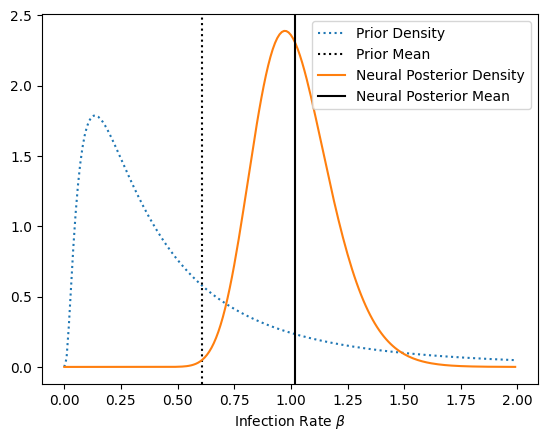

In [13]:
prior_mean = np.exp(prior_mu + prior_sigma**2/2)

prior = norm(prior_mu, prior_sigma)

np.random.seed(10)
x = np.arange(0., 2, 0.01)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Neural Posterior Density")
plt.axvline(posterior_mean, color="k", label="Neural Posterior Mean")
# plt.axvline(true_post_exp, color="red", linestyle="--", label=r"Exact Posterior Mean")
ax.set_xlabel(r"Infection Rate $\beta$")
# ax.set_title(f"Neural Posterior Inference of Infection Rate")
plt.legend()
# plt.savefig("images/npe_homog.png")
plt.show()

#### posterior predictive checks

In [34]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=False)

In [47]:
posterior_predictive.shape

(30, 53)

In [56]:
x_baseline = crkp_model.CRKP_simulator(-1e8, 100)

In [62]:
pop = crkp_model.W.sum(0)

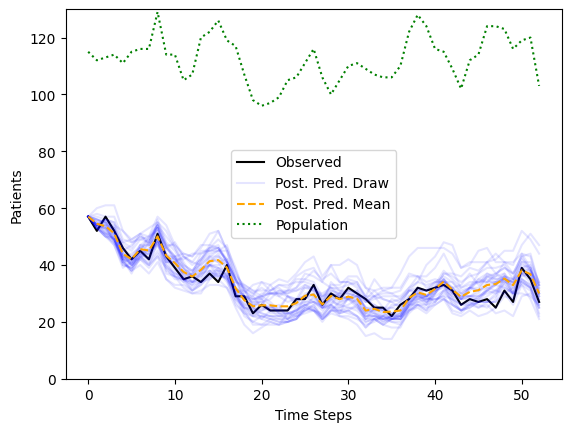

In [69]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(x_baseline, label="Only Admitted", linestyle=":", color="k")
plt.plot(pop, label="Population", color="g", linestyle=":")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/ppc.png")
plt.ylim(0, 130)
plt.show()

In [73]:
pop

array([115, 112, 113, 114, 111, 115, 116, 116, 129, 114, 114, 105, 107,
       120, 122, 126, 119, 117, 107,  98,  96,  97,  99, 105, 106, 111,
       116, 106, 100, 105, 110, 111, 109, 107, 106, 106, 110, 122, 128,
       124, 116, 115, 109, 102, 112, 114, 124, 124, 123, 116, 119, 120,
       103])

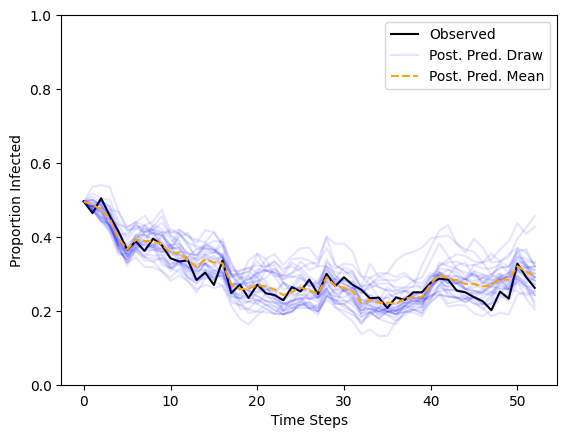

In [75]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i) / pop
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0] / pop
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(x_baseline, label="Only Admitted", linestyle=":", color="k")
# plt.plot(pop, label="Population", color="g", linestyle=":")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
# plt.savefig("images/ppc.png")
plt.ylim(0, 1)
plt.show()

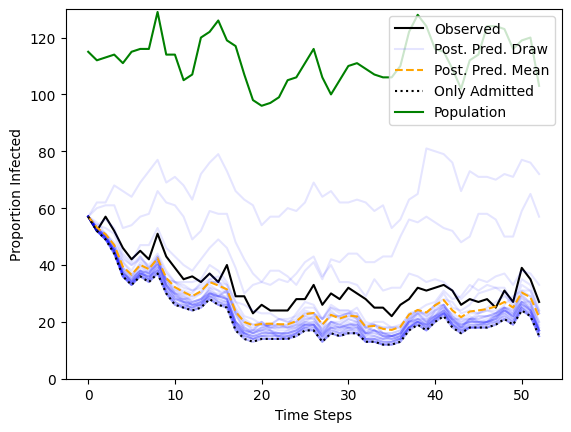

In [65]:
neural_posterior = norm(-1, 1)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.plot(x_baseline, label="Only Admitted", linestyle=":", color="k")
plt.plot(pop, label="Population", color="g")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
# plt.savefig("images/ppc.png")
plt.ylim(0, 130)
plt.show()

## Heterogeneous

In [4]:
prior_mu = [-2, -1, -1, -1, -1, -1, -1, 0]
prior_sigma = [1, 1, 1, 1, 1, 1, 1, 1]

In [5]:
het = True
flatten = True
start_time = timer()
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, n_sample=1000, heterogeneous=het, flatten=flatten)
end_time = timer()
print(f"Time lapsed: {end_time - start_time:.2f} seconds")

Time lapsed: 8.09 seconds
